In [3]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append('../../../module/')

from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam
import csv
import itertools
from util import *
import gym2
from rl2.agents import selfDDPGAgent, selfDDPGAgent2, selfDDPGAgent3
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [4]:
env = gym2.make('Linear-v1')
Q = .01 * np.eye(2)
R = .01

In [49]:
def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

def value_net(s_shape):
    state_input = Input((1,)+s_shape)
    x = Flatten()(state_input)
    
    x = Dense(16, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    x = Dense(1, activation="linear")(x)
    value = Model(inputs=state_input, output=x)
    return value

def branch_actor(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input) # 実質的なinput layer
    
    x1 = Dense(16, activation="relu")(x)
    x1 = Dense(16, activation="relu")(x1)
    x1 = Dense(1, activation="multiple_tanh")(x1) # action signal
    
    x2 = Dense(16, activation="relu")(x)
    x2 = Dense(16, activation="relu")(x2)
    x2 = Dense(1, activation="tau_output_large")(x2) # tau
    
    output = concatenate([x1, x2])
    actor = Model(inputs=action_input, outputs=output)
    return actor

In [11]:
actor = branch_actor((2,),(2,))

In [77]:
# init
actor.load_weights('../saved_agent/linear_init_extend_actor.h5')

In [78]:
alpha = 0.4
beta = 1.

smemory = []
end_time = 10.
l = 1.
n_episodes = 1000
gamma = .99

for i in range(n_episodes):
    env.reset()
    episode_time = 0
    episode_step = 0
    episode_memory = []
    while True:
        reward = 0
        state0 = env.state
        a_agent, tau = actor.predict_on_batch(np.array([[state0]]))[0]
        a_agent, tau = np.clip(a_agent, -10., 10.), np.clip(tau, .01, 10.)
        action_repetition = int(np.ceil(20 * tau))  # minimum natural number which makes `dt` smaller than 0.005
        dt = tau / action_repetition
        episode_time += tau
        for p in range(action_repetition):
            _,r,_,_ = env.step(np.array([a_agent]), dt, tau)
            r *= np.exp(- alpha * p * dt)
            reward += r
        reward *= dt
        reward -= beta
        state1 = env.state
        if np.random.uniform(0,1) < np.exp(- alpha * episode_step):
            episode_memory.append([state0, np.array([a_agent, tau]), reward, state1])
        episode_step += 1
        if episode_time > end_time:
            break
    print('\r' + f'{int(i*100/n_episodes)} %', end='')
    smemory.append(np.array(episode_memory))

99 %

In [79]:
memory = np.array(list(itertools.chain.from_iterable(np.array(smemory))))
print(memory.shape)

(3046, 4)


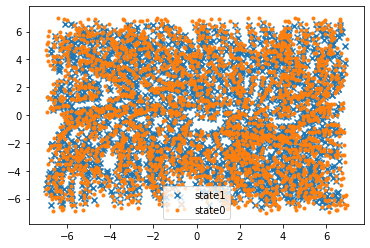

In [80]:
action_memory = np.array(memory[:,1].tolist())
state0_memory = np.array(memory[:,0].tolist())
state1_memory = np.array(memory[:,3].tolist())
plt.scatter(state1_memory[:,0], state1_memory[:,1], marker='x', label='state1')
plt.scatter(state0_memory[:,0], state0_memory[:,1], marker='.', label='state0')
plt.legend()
plt.show()

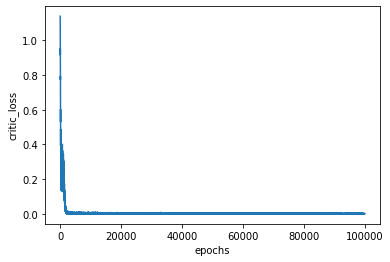

In [81]:
# critic learning
critic = critic_net((2,),(2,))[0]
critic.compile(Adam(lr=0.001, clipnorm=1.), loss='mean_squared_error')
critic.load_weights('../saved_agent/linear_init_extend_critic.h5')
epoch = 100000
batch_size = 64
arr = np.array(range(memory.shape[0]))
losses = []
for _ in range(epoch):
    # make mini_batch
    mem = memory[np.random.choice(arr, batch_size, replace=False)]
    state0_batch = []
    action_batch = []
    reward_batch = []
    state1_batch = []
    for m in mem:
        state0_batch.append([m[0]])
        action_batch.append(m[1])
        reward_batch.append([m[2]])
        state1_batch.append([m[3]])
    state0_batch, action_batch, reward_batch, state1_batch = \
    np.array(state0_batch), np.array(action_batch), np.array(reward_batch), np.array(state1_batch)

    # TD error
    next_action = actor.predict_on_batch(state1_batch)
    state1_batch_with_action = [next_action, state1_batch]
    target = critic.predict_on_batch(state1_batch_with_action)
    discount = np.exp(- alpha * action_batch[:,1].reshape(batch_size, 1))
    r_second = np.multiply(discount, target)
    r = reward_batch + r_second
    
    # learn
    critic_input_batch = [action_batch, state0_batch]
    loss = critic.train_on_batch(critic_input_batch, r)
    losses.append(loss)
    
plt.plot(losses)
plt.xlabel('epochs')
plt.ylabel('critic_loss')
plt.show()

In [82]:
critic.save_weights('../saved_agent/linear_init_extend_critic_l.h5')

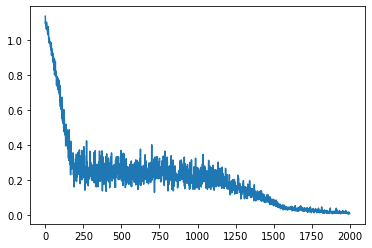

In [87]:
plt.plot(losses[:2000])

In [6]:
# unstable policy
actor.load_weights('../saved_agent/proposed3_actor.h5')

In [10]:
alpha = 0.4
beta = 1.

smemory = []
end_time = 20.
l = 1.
n_episodes = 20
gamma = .99

for i in range(n_episodes):
    env.reset()
    episode_time = 0
    episode_step = 0
    episode_memory = []
    while True:
        reward = 0
        state0 = env.state
        a_agent, tau = actor.predict_on_batch(np.array([[state0]]))[0]
        a_agent, tau = np.clip(a_agent, -10., 10.), np.clip(tau, .01, 10.)
        action_repetition = int(np.ceil(20 * tau))  # minimum natural number which makes `dt` smaller than 0.005
        dt = tau / action_repetition
        episode_time += tau
        for p in range(action_repetition):
            _,r,_,_ = env.step(np.array([a_agent]), dt, tau)
            r *= np.exp(- alpha * p * dt)
            reward += r
        reward *= dt
        reward -= beta
        state1 = env.state
        #if np.random.uniform(0,1) < np.exp(- alpha * episode_step):
        episode_memory.append([state0, np.array([a_agent, tau]), reward, state1])
        episode_step += 1
        if episode_time > end_time:
            break
    print('\r' + f'{int(i*100/n_episodes)} %', end='')
    smemory.append(np.array(episode_memory))

95 %

In [11]:
memory = np.array(list(itertools.chain.from_iterable(np.array(smemory))))
print(memory.shape)

(40020, 4)


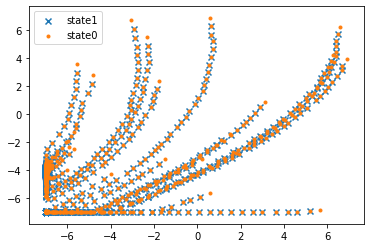

In [12]:
action_memory = np.array(memory[:,1].tolist())
state0_memory = np.array(memory[:,0].tolist())
state1_memory = np.array(memory[:,3].tolist())
plt.scatter(state1_memory[:,0], state1_memory[:,1], marker='x', label='state1')
plt.scatter(state0_memory[:,0], state0_memory[:,1], marker='.', label='state0')
plt.legend()
plt.show()

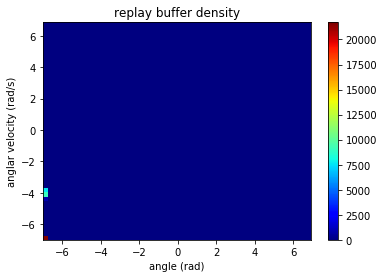

In [13]:
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
fig = plt.figure()
ax = fig.add_subplot(111)
H = ax.hist2d(state0_memory[:,0], state0_memory[:,1], bins=50, cmap=cm.jet)
# H[3].set_clim(0,200)
fig.colorbar(H[3],ax=ax)
ax.set_title('replay buffer density')
ax.set_xlabel('angle (rad)')
ax.set_ylabel('anglar velocity (rad/s)')
plt.show()

Instructions for updating:
Use tf.cast instead.


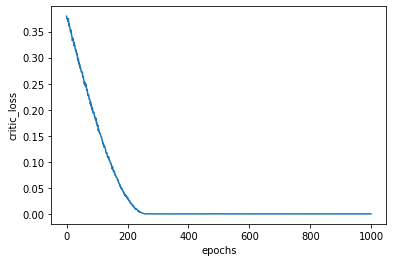

In [14]:
# critic learning
critic = critic_net((2,),(2,))[0]
critic.compile(Adam(lr=0.01, clipnorm=1.), loss='mean_squared_error')
critic.load_weights('../saved_agent/proposed3_critic.h5')
epoch = 1000
batch_size = 64
arr = np.array(range(memory.shape[0]))
losses = []
for _ in range(epoch):
    # make mini_batch
    mem = memory[np.random.choice(arr, batch_size, replace=False)]
    state0_batch = []
    action_batch = []
    reward_batch = []
    state1_batch = []
    for m in mem:
        state0_batch.append([m[0]])
        action_batch.append(m[1])
        reward_batch.append([m[2]])
        state1_batch.append([m[3]])
    state0_batch, action_batch, reward_batch, state1_batch = \
    np.array(state0_batch), np.array(action_batch), np.array(reward_batch), np.array(state1_batch)

    # TD error
    next_action = actor.predict_on_batch(state1_batch)
    state1_batch_with_action = [next_action, state1_batch]
    target = critic.predict_on_batch(state1_batch_with_action)
    discount = np.exp(- alpha * action_batch[:,1].reshape(batch_size, 1))
    r_second = np.multiply(discount, target)
    r = reward_batch + r_second
    
    # learn
    critic_input_batch = [action_batch, state0_batch]
    loss = critic.train_on_batch(critic_input_batch, r)
    losses.append(loss)
    
plt.plot(losses)
plt.xlabel('epochs')
plt.ylabel('critic_loss')
plt.show()

In [23]:
critic.save_weights('../saved_agent/proposed3_critic_l.h5')

In [50]:
# good agent
actor.load_weights('../saved_agent/learned_self_linear1_extend_actor.h5')

In [63]:
alpha = 0.4
beta = 1.

smemory = []
end_time = 20.
l = 1.
n_episodes = 3000
gamma = .99

for i in range(n_episodes):
    env.reset()
    episode_time = 0
    episode_step = 0
    episode_memory = []
    while True:
        reward = 0
        state0 = env.state
        a_agent, tau = actor.predict_on_batch(np.array([[state0]]))[0]
        a_agent, tau = np.clip(a_agent, -10., 10.), np.clip(tau, .01, 10.)
        action_repetition = int(np.ceil(20 * tau))  # minimum natural number which makes `dt` smaller than 0.005
        dt = tau / action_repetition
        episode_time += tau
        for p in range(action_repetition):
            _,r,_,_ = env.step(np.array([a_agent]), dt, tau)
            r *= np.exp(- alpha * p * dt)
            reward += r
        reward *= dt
        reward -= beta
        state1 = env.state
        if np.random.uniform(0,1) < np.exp(- alpha * episode_step):
            episode_memory.append([state0, np.array([a_agent, tau]), reward, state1])
        episode_step += 1
        if episode_time > end_time:
            break
    print('\r' + f'{int(i*100/n_episodes)} %', end='')
    smemory.append(np.array(episode_memory))

99 %

In [64]:
memory = np.array(list(itertools.chain.from_iterable(np.array(smemory))))
print(memory.shape)

(9058, 4)


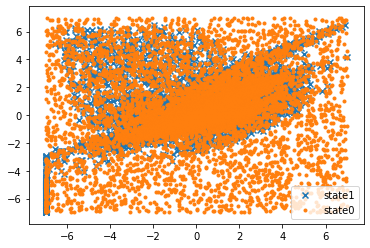

In [65]:
action_memory = np.array(memory[:,1].tolist())
state0_memory = np.array(memory[:,0].tolist())
state1_memory = np.array(memory[:,3].tolist())
plt.scatter(state1_memory[:,0], state1_memory[:,1], marker='x', label='state1')
plt.scatter(state0_memory[:,0], state0_memory[:,1], marker='.', label='state0')
plt.legend()
plt.show()

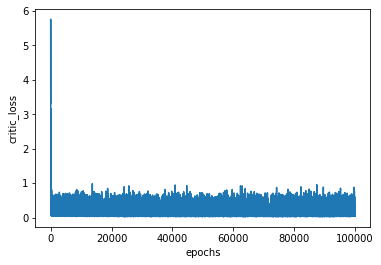

In [67]:
# critic learning
critic = critic_net((2,),(2,))[0]
critic.compile(Adam(lr=0.001, clipnorm=1.), loss='mean_squared_error')
critic.load_weights('../saved_agent/learned_self_linear1_extend_critic.h5')
epoch = 100000
batch_size = 64
arr = np.array(range(memory.shape[0]))
losses = []
for _ in range(epoch):
    # make mini_batch
    mem = memory[np.random.choice(arr, batch_size, replace=False)]
    state0_batch = []
    action_batch = []
    reward_batch = []
    state1_batch = []
    for m in mem:
        state0_batch.append([m[0]])
        action_batch.append(m[1])
        reward_batch.append([m[2]])
        state1_batch.append([m[3]])
    state0_batch, action_batch, reward_batch, state1_batch = \
    np.array(state0_batch), np.array(action_batch), np.array(reward_batch), np.array(state1_batch)

    # TD error
    next_action = actor.predict_on_batch(state1_batch)
    state1_batch_with_action = [next_action, state1_batch]
    target = critic.predict_on_batch(state1_batch_with_action)
    discount = np.exp(- alpha * action_batch[:,1].reshape(batch_size, 1))
    r_second = np.multiply(discount, target)
    r = reward_batch + r_second
    
    # learn
    critic_input_batch = [action_batch, state0_batch]
    loss = critic.train_on_batch(critic_input_batch, r)
    losses.append(loss)
    
plt.plot(losses)
plt.xlabel('epochs')
plt.ylabel('critic_loss')
plt.show()

In [68]:
critic.save_weights('../saved_agent/learned_self_linear1_extend_critic_l.h5')

In [ ]:
# learning with V(s|η)

In [50]:
vn = value_net((2,))
vn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 1, 2)              0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 2)                 0         
_________________________________________________________________
dense_25 (Dense)             (None, 16)                48        
_________________________________________________________________
dense_26 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 17        
Total params: 337
Trainable params: 337
Non-trainable params: 0
_________________________________________________________________


In [58]:
actor.load_weights('../saved_agent/learned_self_linear1_extend_actor.h5')
# actor.load_weights('../saved_agent/linear_init_extend_actor.h5')

In [59]:
alpha = 0.4
beta = 1.

memory = []
S1 = np.linspace(-7, 7, 100)
S2 = np.linspace(-7, 7, 100)
S1, S2 = np.meshgrid(S1, S2)
S1, S2 = S1.flatten(), S2.flatten()

for i, x in enumerate(zip(S1, S2)):
    env.reset()
    x = np.array(x)
    env.set_state(x)
    reward = 0
    state0 = env.state
    a_agent, tau = actor.predict_on_batch(state0.reshape((1,1,)+state0.shape))[0]
    tau = np.clip(tau, 0.01, 10.)
    action_repetition = int(np.ceil(20 * tau))  # minimum natural number which makes `dt` smaller than 0.005
    dt = tau / action_repetition
    for p in range(action_repetition):
        _,r,_,_ = env.step(np.array([a_agent]), dt, tau)
        r *= np.exp(- alpha * p * dt)
        reward += r
    reward *= dt
    reward -= beta
    state1 = env.state
    memory.append([state0, np.array([a_agent, tau]), reward, state1])
    print('\r' + f'{int(i*100/len(S1))} %', end='')
memory = np.array(memory)

99 %

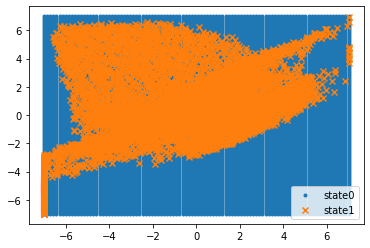

In [60]:
action_memory = np.array(memory[:,1].tolist())
state0_memory = np.array(memory[:,0].tolist())
state1_memory = np.array(memory[:,3].tolist())
plt.scatter(state0_memory[:,0], state0_memory[:,1], marker='.', label='state0')
plt.scatter(state1_memory[:,0], state1_memory[:,1], marker='x', label='state1')
plt.legend()
plt.show()

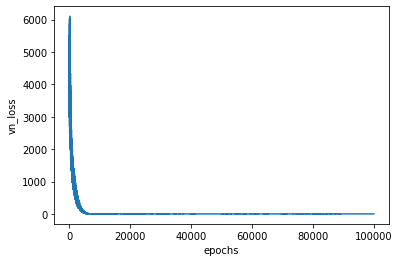

In [61]:
# critic learning
vn.compile(Adam(lr=0.0001, clipnorm=1.), loss='mean_squared_error')
epoch = 100000
batch_size = 64
arr = np.array(range(memory.shape[0]))
losses = []
for _ in range(epoch):
    # make mini_batch
    mem = memory[np.random.choice(arr, batch_size, replace=False)]
    state0_batch = []
    action_batch = []
    reward_batch = []
    state1_batch = []
    for m in mem:
        state0_batch.append([m[0]])
        action_batch.append(m[1])
        reward_batch.append([m[2]])
        state1_batch.append([m[3]])
    state0_batch, action_batch, reward_batch, state1_batch = \
    np.array(state0_batch), np.array(action_batch), np.array(reward_batch), np.array(state1_batch)

    # TD error
    target = vn.predict_on_batch(state1_batch)
    discount = np.exp(- alpha * action_batch[:,1].reshape(batch_size, 1))
    r_second = np.multiply(discount, target)
    r = reward_batch + r_second
    
    # learn
    loss = vn.train_on_batch(state0_batch, r)
    losses.append(loss)
    
plt.plot(losses)
plt.xlabel('epochs')
plt.ylabel('vn_loss')
plt.show()

In [62]:
vn.save_weights('../saved_agent/value_net_learned.h5')